In [1]:
import os
import skimage.io as io
import numpy as np
from pycocotools.coco import COCO
import cython
import random
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


#### load data

In [2]:
COCO_ROOT = 'D:/GeekBrains/comp_vision/les04/data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))

In [3]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [4]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['cat'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [5]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.93s)
creating index...
index created!
loading annotations into memory...
Done (t=1.64s)
creating index...
index created!


In [6]:
INP_SIZE = 128
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [7]:
train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, NUM_EPOCHS, INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, INP_SIZE)

In [8]:
print('train shape:', tf.data.experimental.cardinality(train_ds).numpy()*BATCH_SIZE)
print('valid shape:', tf.data.experimental.cardinality(val_ds).numpy()*BATCH_SIZE)

train shape: 41120
valid shape: 160


#### show data

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

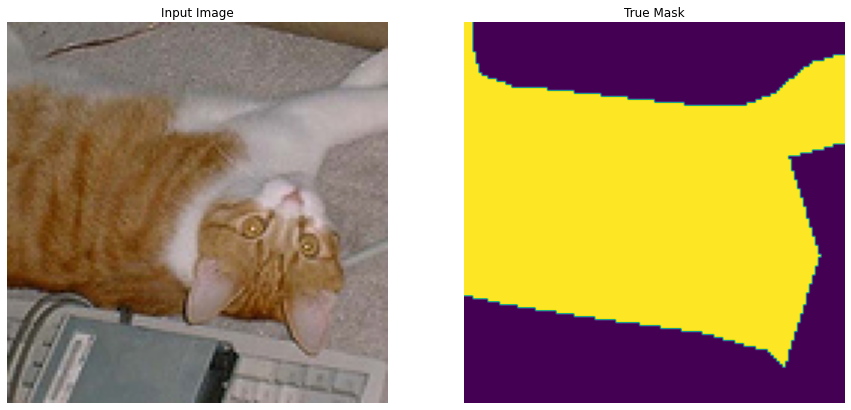

In [10]:
for image, mask in val_ds.take(1):
    sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

#### model

##### ASPP

In [11]:
# # ASPP
# def build_model():
#     #### encoder
#     x = tf.keras.layers.Input((128, 128, 3))
    
#     out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x) #0
#     out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out) #1
#     out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
#     out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out) #2
#     out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out) #3
#     out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
#     out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out) #4
#     out_c1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out) #5 needs connect
#     out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out_c1)
#     out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out_c1) #6
#     out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out) #7
#     out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
#     out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out) #8
#     out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out) #9
    
#     #### ASPP block
#     out_a1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out) #10
#     out_a2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(out) #11
#     out_a3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(out) #12
#     out_a4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(out) #13
#     out = tf.concat([out_a1, out_a2, out_a3, out_a4], axis=3)
#     out = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out) #14
    
#     #### decoder
#     out = tf.image.resize(out, tf.shape(out_c1)[1:3], tf.image.ResizeMethod.BILINEAR)
#     out = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')(out) ####
#     out = tf.concat([out, out_c1], axis=3) # connect
#     out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
#     out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
#     out = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)(out)
#     out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
# #     out = tf.nn.sigmoid(out)
    
#     return tf.keras.Model(inputs=x, outputs=out)

In [12]:
# model = build_model()

In [13]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

##### U-net

In [14]:
# ENCODER
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

# DECODER
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]



In [15]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
model = unet_model(3)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

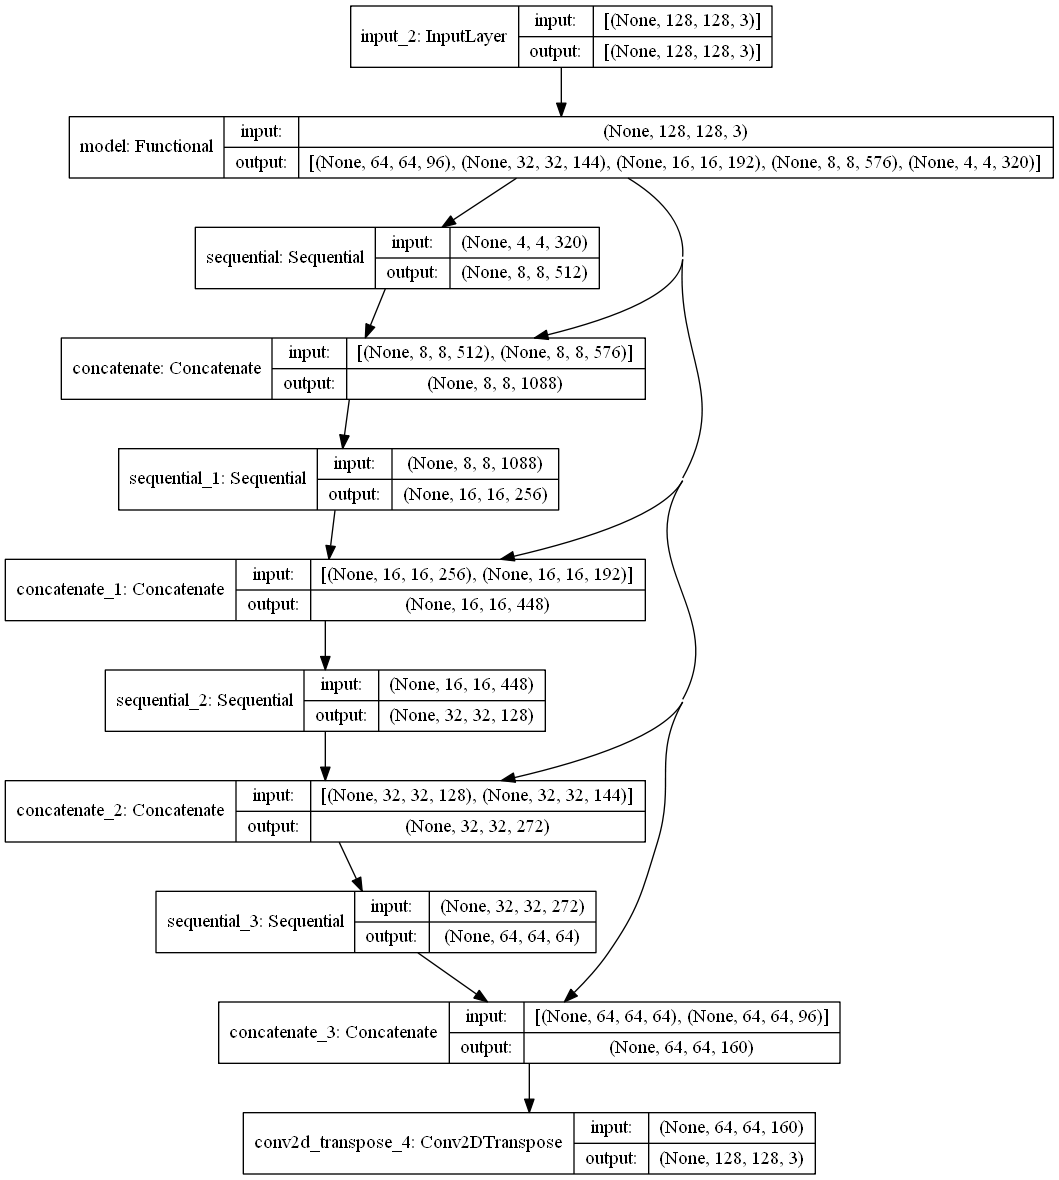

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

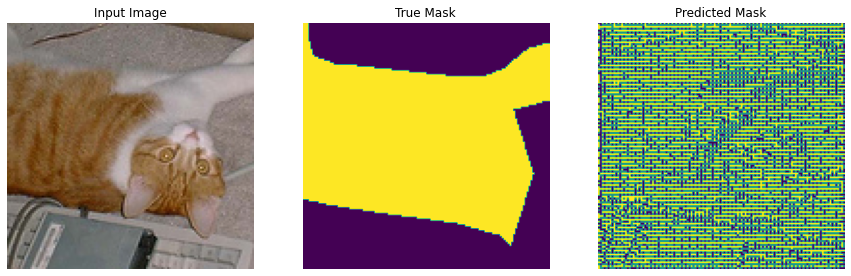

In [20]:
show_predictions() #before fitting

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

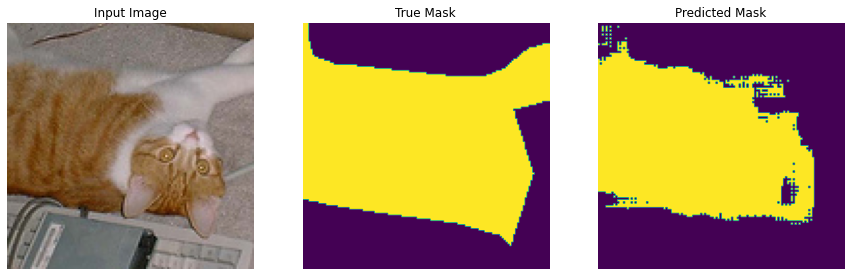


Sample Prediction after epoch 10

Wall time: 1h 37min 27s


In [22]:
%%time
with tf.device('/device:GPU:0'):
    history_model = model.fit(
        train_ds,
        epochs=NUM_EPOCHS,
        validation_data=val_ds,
        callbacks=[DisplayCallback()]
    ).history

In [23]:
model.evaluate(val_ds)

5/5 [==============================] - 2s 363ms/step - loss: 0.2595 - accuracy: 0.5205


[0.2594752013683319, 0.5204712152481079]

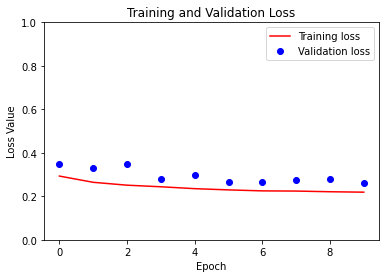

In [26]:
loss = history_model['loss']
val_loss = history_model['val_loss']

epochs = range(NUM_EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#### get prediction

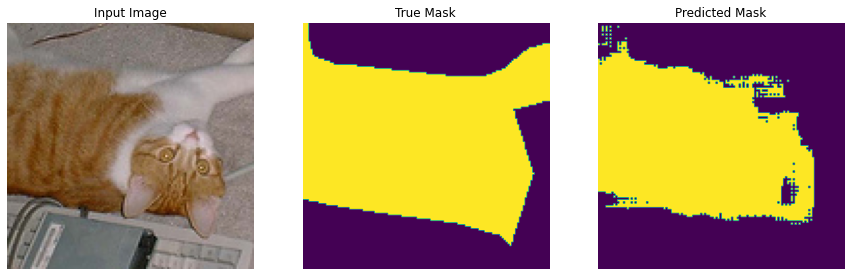

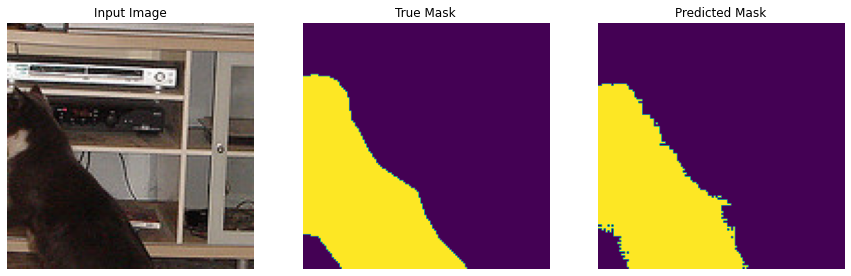

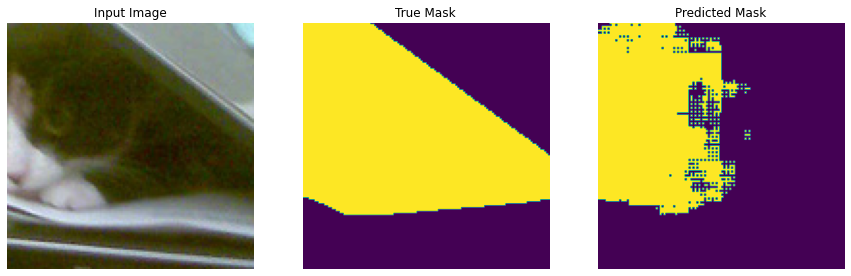

In [27]:
for image, mask in val_ds.take(3):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])